In [1]:
import sys, os, ndreg, skimage
import matplotlib.pyplot as plt
from matplotlib import cm
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import missing_data as mdmask
import ingest_tif_stack as ingest

In [322]:
import registerer_copy as reg
import preprocessor_copy as pre
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
atlas_resolution = 50
atlas = ndreg.imgRead('./atlas/ara_atlas.img')
atlas_width, atlas_height, atlas_depth = atlas.GetSize()

full_img = ndreg.imgRead('./missing_insula/whole_insula.img')
orientation_atlas = 'pir'
orientation_image = 'lps'
full_img = ndreg.imgReorient(full_img, orientation_image, orientation_atlas)
full_img_width, full_img_height, full_img_depth = full_img.GetSize()

missing_img = ndreg.imgRead('./missing_insula/half_insula.img')
missing_img = ndreg.imgReorient(missing_img, orientation_image, orientation_atlas)
img_width, img_height, img_depth = missing_img.GetSize()

padded_img, padded_mask = mdmask.pad_img_with_range(missing_img, depth_range=(0,abs(img_depth-full_img_depth)))

missing_array = mdmask.gen_frac_mask(atlas_depth, atlas_height, atlas_width, 0.5, 0, side='left')
missing_mask = mdmask.convert_to_image(missing_array.astype('uint16'))
missing_mask.CopyInformation(atlas)
half_atlas = mdmask.mask_img(atlas, missing_mask)

# Inputs

## Atlas

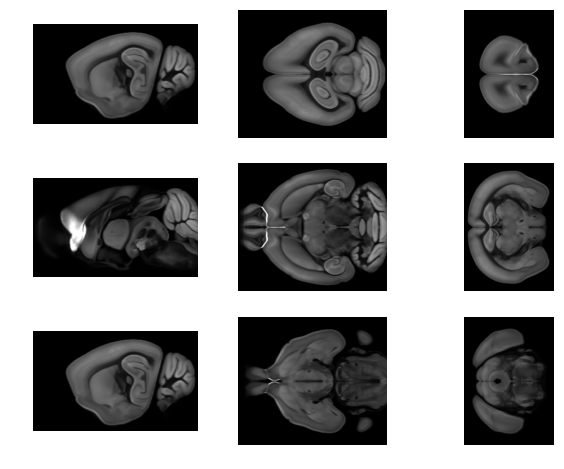

In [4]:
ndreg.imgShow(atlas)

## Half Atlas

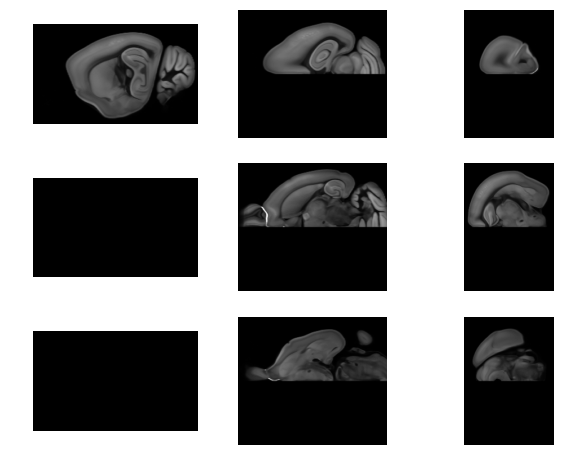

In [5]:
ndreg.imgShow(half_atlas)

## Insula with partially missing nose

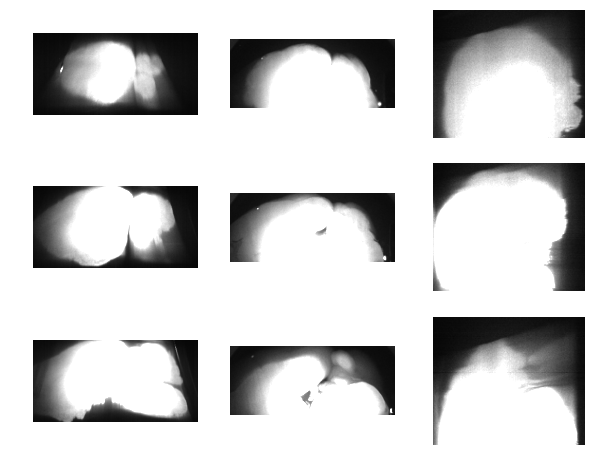

In [6]:
ndreg.imgShow(missing_img, vmax=2500)

## Padded target image

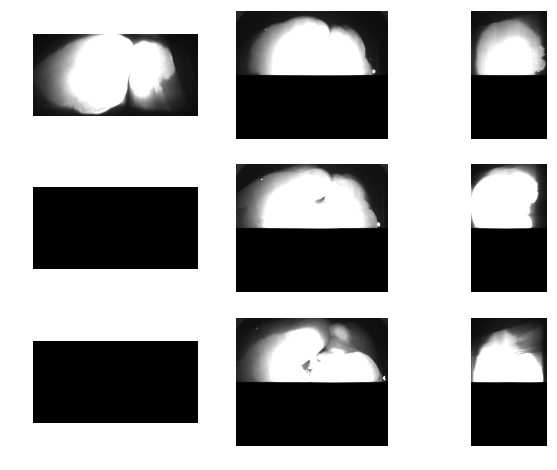

In [7]:
ndreg.imgShow(padded_img, vmax=2500)

## Scenario of known missing data: pad image with an estimate of how much is missing

In [8]:
# Bias correction
mask_dilation_radius = 10 # voxels
mask_bc = sitk.BinaryDilate(pre.create_mask(padded_img, use_triangle=True), mask_dilation_radius)
img_bc, bias = pre.correct_bias_field(padded_img, scale=0.25, spline_order=4, mask=mask_bc,
                                     num_control_pts=[5,5,5],
                                     niters=[50, 50, 50, 50])
atlas_n = sitk.Normalize(atlas)
half_atlas_n = sitk.Normalize(half_atlas)
img_bc_n = sitk.Normalize(img_bc)

## With full atlas

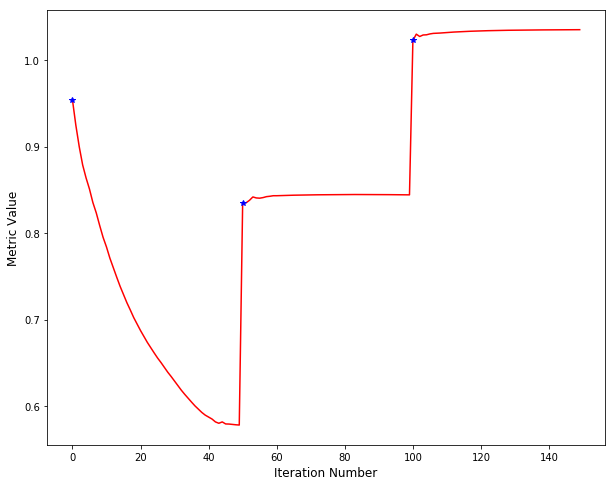

In [9]:
# Compute affine transform
final_transform_full_atlas = reg.register_affine(atlas_n,
                                    img_bc_n,
                                    learning_rate=1e-1,
                                    grad_tol=4e-6,
                                    use_mi=False,
                                    iters=50,
                                    shrink_factors=[4,2,1],
                                    sigmas=[0.4, 0.2, 0.1],
                                    verbose=True)

In [10]:
atlas_affine_full_atlas = reg.resample(atlas, final_transform_full_atlas, img_bc, default_value=ndreg.imgPercentile(atlas,0.01))


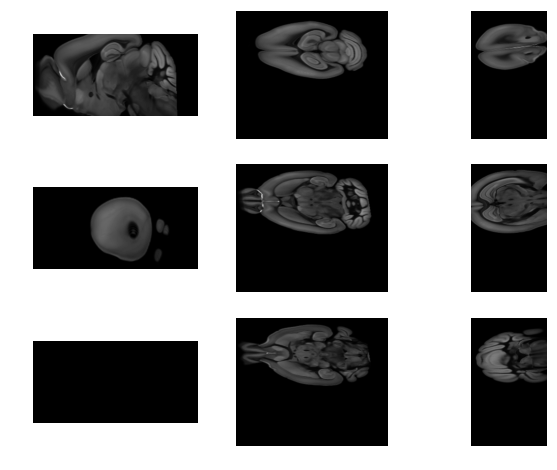

In [11]:
ndreg.imgShow(atlas_affine_full_atlas)

In [12]:
# whiten the images
full_atlas_affine_w = sitk.AdaptiveHistogramEqualization(atlas_affine_full_atlas, [10,10,10], alpha=0.25, beta=0.25)
img_bc_w = sitk.AdaptiveHistogramEqualization(img_bc, [10,10,10], alpha=0.25, beta=0.25)

In [13]:
# LDDMM
e = 5e-3
s = 0.1
full_atlas_lddmm, field, inv_field = reg.register_lddmm(affine_img=sitk.Normalize(full_atlas_affine_w), 
                                                          target_img=sitk.Normalize(img_bc_w),
                                                          alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=e, sigma=s,
                                                          min_epsilon_list=e*1e-6,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	83237.7, 351.708, 0, 82886 (96.2116%), 5.500000e-03
1.	80091.3, 775.528, 0, 79315.7 (92.0673%), 6.050000e-03
2.	78501.7, 865.239, 0, 77636.5 (90.1181%), 3.327500e-03
3.	78236.7, 884.04, 0, 77352.6 (89.7886%), 9.150625e-04
4.	78156.6, 898.924, 0, 77257.6 (89.6784%), 5.032844e-04
5.	78117.1, 915.884, 0, 77201.2 (89.6128%), 5.536128e-04
6.	77855.1, 935.031, 0, 76920.1 (89.2865%), 6.089741e-04
7.	77437.4, 960.601, 0, 76476.8 (88.772%), 6.698715e-04
8.	76556.9, 994.386, 0, 75562.5 (87.7107%), 7.368587e-04
9.	76106.3, 1032.11, 0, 75074.2 (87.1439%), 8.105445e-04
10.	76074, 1072.9, 0, 75001.1 (87.059%), 8.915990e-04
11.	75707.5, 1122.73, 0, 74584.8 (86.5758%), 9.807589e-04
12.	75682.3, 1149.38, 0, 74532.9 (86.5155%), 5.394174e-04
13.	75541.4, 1177.34, 0, 74364.1 (86.3196%), 5.933591e-04
14.	75120.7, 1207.29, 0, 73913.5 (85.7965%), 6.526950e-04
15.	74409, 1241.34, 0, 73167.7 (84.9309%), 7.


Step 4: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	62496.9, 4.55293, 0, 62492.3 (98.6749%), 2.750000e-03
1.	61194.6, 1.23352, 0, 61193.4 (96.6239%), 1.512500e-03
2.	60852.7, 2.66386, 0, 60850 (96.0817%), 1.663750e-03
3.	60632.5, 2.4828, 0, 60630 (95.7342%), 1.830125e-03
4.	60570, 2.4909, 0, 60567.5 (95.6356%), 1.258211e-04
E = 60570 (95.6356%)
Length = 1.81226
Time = 1068s (17.8m)


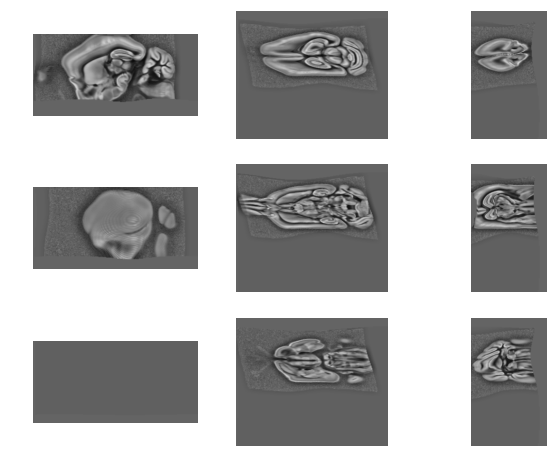

In [14]:
ndreg.imgShow(full_atlas_lddmm)

## With half atlas

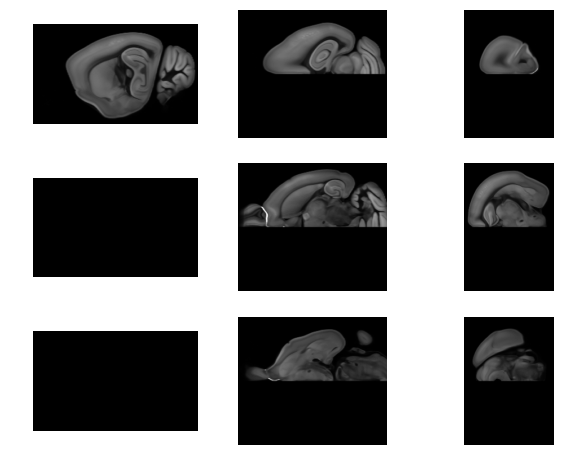

In [15]:
ndreg.imgShow(half_atlas_n)

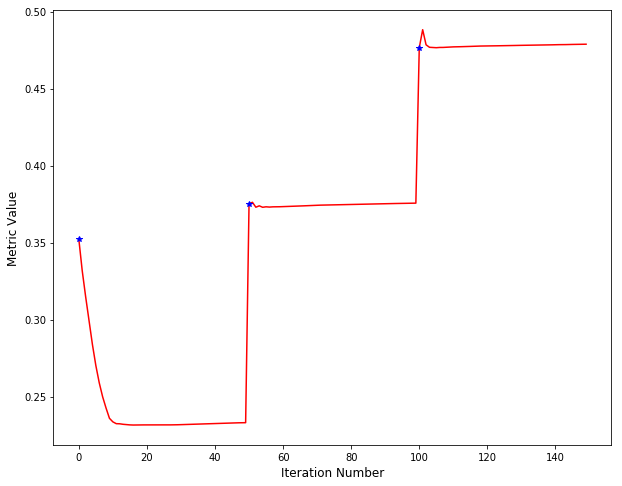

In [16]:
# Compute affine transform
final_transform_half_atlas = reg.register_affine(half_atlas_n,
                                    img_bc_n,
                                    learning_rate=1e-1,
                                    grad_tol=4e-6,
                                    use_mi=False,
                                    iters=50,
                                    shrink_factors=[4,2,1],
                                    sigmas=[0.4, 0.2, 0.1],
                                    verbose=True)

In [17]:
half_atlas_affine = reg.resample(half_atlas, final_transform_half_atlas, img_bc, default_value=ndreg.imgPercentile(atlas,0.01))


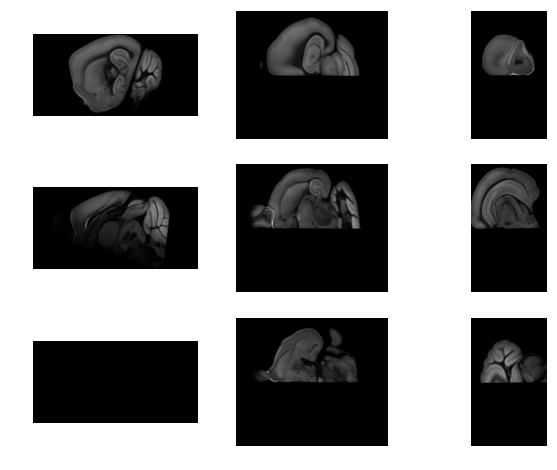

In [18]:
ndreg.imgShow(half_atlas_affine)

In [19]:
# whiten the images
half_atlas_affine_w = sitk.AdaptiveHistogramEqualization(half_atlas_affine, [10,10,10], alpha=0.25, beta=0.25)
img_bc_w = sitk.AdaptiveHistogramEqualization(img_bc, [10,10,10], alpha=0.25, beta=0.25)

In [ ]:
# LDDMM
e = 5e-3
s = 0.1
half_atlas_lddmm, field, inv_field = reg.register_lddmm(affine_img=sitk.Normalize(half_atlas_affine_w), 
                                                          target_img=sitk.Normalize(img_bc_w),
                                                          alpha_list=[0.05],
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=e, sigma=s,
                                                          min_epsilon_list=e*1e-6,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	73168.6, 39.568, 0, 73129 (92.8473%), 1.375000e-03
1.	67419.5, 57.5883, 0, 67361.9 (85.5252%), 1.512500e-03
2.	65634.2, 100.679, 0, 65533.5 (83.2037%), 1.663750e-03
3.	62343.9, 171.334, 0, 62172.6 (78.9366%), 1.830125e-03
4.	62240, 198.553, 0, 62041.5 (78.7701%), 1.006569e-03
5.	61793.1, 220.71, 0, 61572.4 (78.1746%), 1.107226e-03
E = 61793.1 (78.1746%)
Length = 18.8896
Time = 28.521s (0.47535m)

Step 1: alpha=0.05, beta=0.05, scale=0.125
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	67299, 26.4257, 0, 67272.5 (98.0261%), 5.500000e-03
1.	65536.5, 45.5512, 0, 65490.9 (95.43%), 3.025000e-03
2.	65454.9, 67.9031, 0, 65387 (95.2785%), 3.327500e-03
3.	63244.1, 79.1026, 0, 63165 (92.0407%), 1.830125e-03
4.	62892.7, 93.3481, 0, 62799.3 (91.508%), 2.013138e-03
5.	62555, 112.086, 0, 62442.9 (90.9886%), 2.214451e-03
6.	62132.8, 137.44, 0, 61995.4 (90.3365%), 2.435896e-03
7.	619

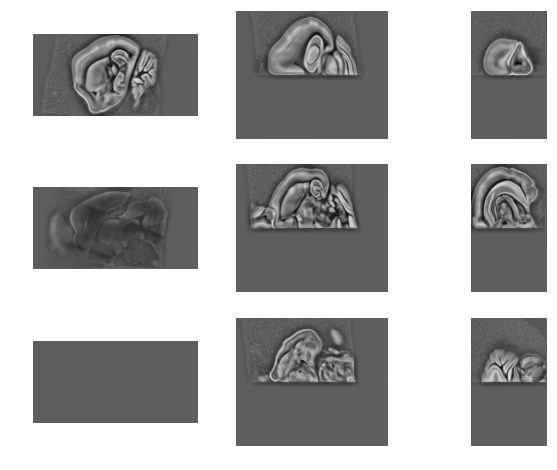

In [22]:
ndreg.imgShow(half_atlas_lddmm)

In [ ]:
half_atlas_lddmm_slice = sitk.GetArrayFromImage(sitk.Normalize(half_atlas_lddmm))[:,50,:]
img_rigid_slice = sitk.GetArrayFromImage(sitk.Normalize(img_bc))[:,50,:]
side_img_slice = sitk.GetArrayFromImage(pre.create_mask(padded_img, use_triangle=True))[:,50,:]

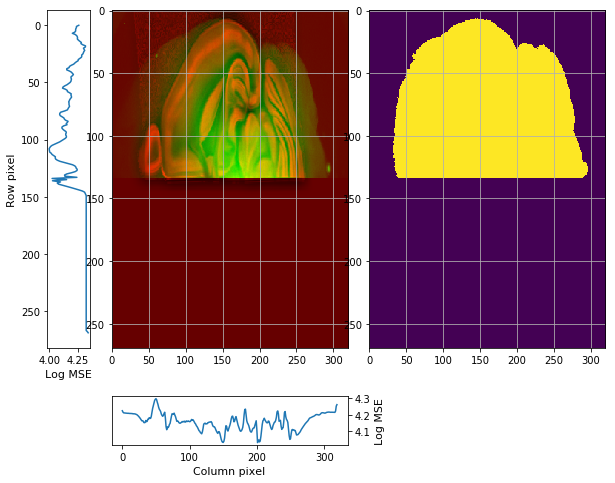

In [335]:
mdmask.plot_mse(half_atlas_lddmm_slice, img_rigid_slice, side_img=side_img_slice, color_blend=True)

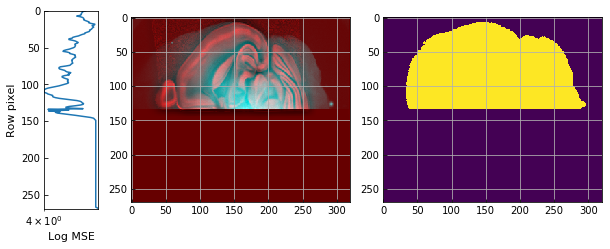

In [336]:
mdmask.plot_mse_with_correct_aspect(half_atlas_lddmm_slice, img_rigid_slice, side_img=side_img_slice, color_blend=True)